In [1]:
from src.aff_core import rho_aff
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs

c:\Users\i00814697\AppData\Local\Programs\Python\Python38\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
sbs.set_context("talk")
cmap = sbs.cubehelix_palette(as_cmap=True)
colorsList = cmap(np.linspace(0, 1, 3))
plt.rcParams.update({'figure.autolayout': True})

In [3]:
np.random.seed(987)
random.seed(987)

n = 1000
d = 1
do_shrink = False

std = 2
acts = ['ReLU', 'Tanh', 'Sigmoid']

C:\Users\i00814697\AppData\Local\Temp\ipykernel_38488\704072563.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes[i].plot(domain, func(torch.tensor(domain)), label='Activation', lw=10)
c:\Users\i00814697\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


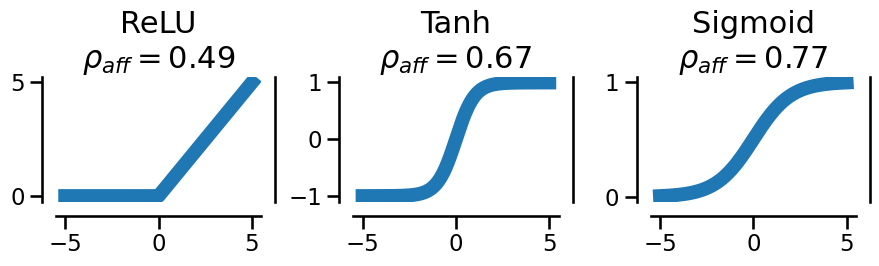

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,3))
fig.tight_layout()

for i,act in enumerate(acts):

    func = getattr(torch.nn.functional, str(act).lower())    
    input = np.random.normal(-1, std, (n,d))    
    output = func(torch.tensor(input, dtype=torch.float))

    aff_score = rho_aff(torch.tensor(input, dtype=torch.float).T, output.T, correctCov=do_shrink, device='cpu')

    domain_np = np.linspace(-5, 5, 1000)
    domain = torch.tensor(domain_np)

    axes[i].plot(domain, func(torch.tensor(domain)), label='Activation', lw=10)
    sbs.despine(fig, axes[i], trim=False, right=False, offset=10)
    
    axes[i].set_title(act+'\n'+r'$\rho_{aff}=$'+str(round(aff_score,2))[:4], fontsize=22)
    axes[i].set_aspect('auto')

In [5]:
nb_means = 20 # we will generate several samples with different means following a uniform distribution to get different scores

xmin = -4
xmax = 4
means = np.linspace(xmin, xmax, nb_means) 
stds = [2.] # this is the spread of the data around the mean

acts = ['relu'] # choose an activation function to analyze

for act in acts:
    print(act)
    scores = np.zeros((nb_means,len(stds)))
    func = getattr(torch.nn.functional, str(act))

    for k,std in enumerate(stds):
        curr_score = []
        curr_r2 = []
        inputs = []

        for i,m in enumerate(means):
            input = np.random.uniform(m-std, m+std, (n,d)) # use uniform distribution for simplicity
            inputs.append(input)  # save input for plotting       
            input = torch.tensor(input, dtype=torch.float)
            output = func(input)

            aff_score = rho_aff(input.T, output.T, correctCov=do_shrink, device='cpu')
            curr_score.append(aff_score)

        scores[:,k] = curr_score

relu


In [9]:
scores = scores.squeeze()
idx_sort = np.argsort(scores)

scores_sorted = scores[idx_sort]
idx_one = np.argwhere(scores_sorted>=0.9999)[0][-1] # to avoid having many identical plots with affinity score = 1
idx_09 = np.argwhere(scores_sorted>0.9)[0][0] # same as above
idxs = list(idx_sort[:idx_09][::3]) + [idx_sort[idx_09]] + [idx_sort[idx_one]] # ::3 here allows to reduce the number of plots, we'll plot every third one

print(idxs)
print(scores[idxs])

[5, 8, 11, 13, 17]
[0.1338768  0.52627778 0.79208457 0.94012427 0.99990737]


C:\Users\i00814697\AppData\Local\Temp\ipykernel_38488\670947732.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes[j].plot(domain, func(torch.tensor(domain)), label='Activation', lw=10)


c:\Users\i00814697\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


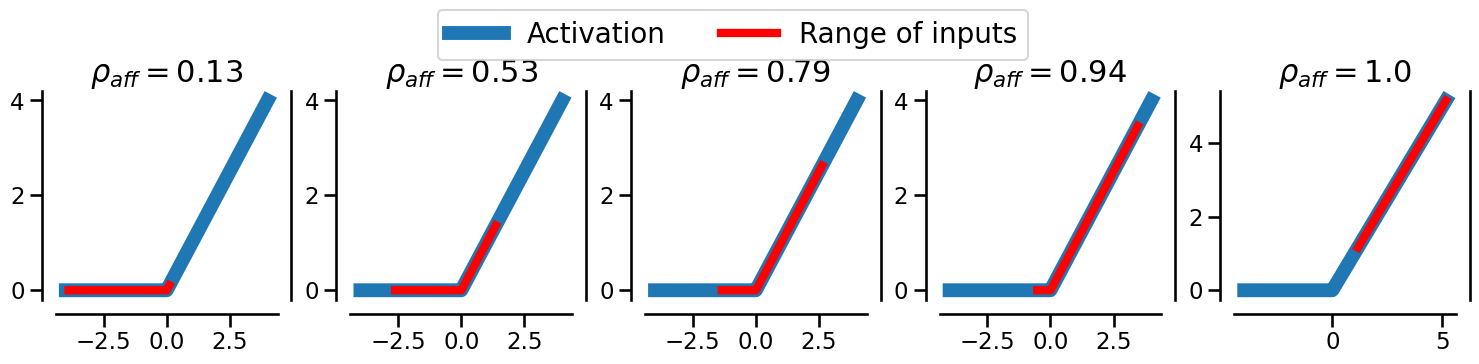

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=len(idxs), figsize=(3*len(idxs), .7*len(idxs)))
fig.tight_layout()

for j, idx in enumerate(idxs):

    domain = torch.tensor(np.linspace(min(np.min(inputs[idx]), xmin), max(xmax,np.max(inputs[idx])), 1000))
    axes[j].plot(domain, func(torch.tensor(domain)), label='Activation', lw=10)
    domain = torch.tensor(np.linspace(np.min(inputs[idx]), np.max(inputs[idx]), 1000))

    output = func(domain)

    if np.allclose(output, 0):
        print('Only 0s here')

    axes[j].plot(domain, output, color='red', lw=6, label='Range of inputs')
    axes[j].set_title(r'$\rho_{aff}=$'+str(round(scores[idx],2))[:4], fontsize=22)
    axes[j].set_aspect('auto')

    sbs.despine(fig, axes[j], trim=False, right=False, offset=10)
    lines, labels = axes[j].get_legend_handles_labels()

plt.figlegend(lines, labels, loc='upper center', bbox_to_anchor=[0.5, 1.1], ncol=2, fontsize=20)